TEAM MEMBERS:
* ***Arjun Sivasankar*** (Matr. No.: 5120708) ⇒ Task 3, Task 4, Task 5
* ***Sparsh Shah***  (Matr. No.: 5127938) ⇒ Task 1, Task 5
* ***Karthikey Nagpal***  (Matr. No.: 5127622) ⇒ Task 2, Task 5

# :::::::::::::::::::::::::::::: **Advanced Methods in Data Analytics Project** ::::::::::::::::::::::::::::

## Package Import

In [ ]:
from fastai.vision.all import *
from fastai.vision import *

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import GTSRB
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.utils.data.sampler as sampler
from torchvision import models
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ToTensor

In [ ]:
import csv
from collections import defaultdict, namedtuple
import os

Presizing and some minor transformations during download

In [ ]:
# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32 pixels
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to the range [-1, 1]
])

## Loading the Dataset

In [ ]:
# Load the GTSRB dataset
train_dataset = GTSRB(root='./data/train', split='train', transform=transform, download=True)
# train_dataset = GTSRB(root='./data/train', split='train', download=True)

100%|██████████| 187490228/187490228 [00:01<00:00, 113273833.15it/s]


Extracting data/train/gtsrb/GTSRB-Training_fixed.zip to data/train/gtsrb


In [ ]:
test_dataset = GTSRB(root='./data/test', split='test', transform=transform, download=True)
# test_dataset = GTSRB(root='./data/test', split='test', download=True)

100%|██████████| 88978620/88978620 [00:00<00:00, 106750226.41it/s]


Extracting data/test/gtsrb/GTSRB_Final_Test_Images.zip to data/test/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 1548408.79it/s]

Extracting data/test/gtsrb/GTSRB_Final_Test_GT.zip to data/test/gtsrb


In [ ]:
train_dataset

Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
test_dataset

Dataset GTSRB
    Number of datapoints: 12630
    Root location: ./data/test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## Exploratory Data Analysis(EDA)

In [ ]:
dir_list = []
rootdir = './data/train/gtsrb/GTSRB/Training'

for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        dir_list.append(file)

print("The no. of classes or labels: ", len(dir_list))

The no. of classes or labels:  43


In [ ]:
# Get the number of training and testing examples
num_train_examples = len(train_dataset)
num_test_examples = len(test_dataset)
print("Number of training examples:", num_train_examples)
print("Number of testing examples:", num_test_examples)

Number of training examples: 26640
Number of testing examples: 12630


#### Distribution of image heights and widths

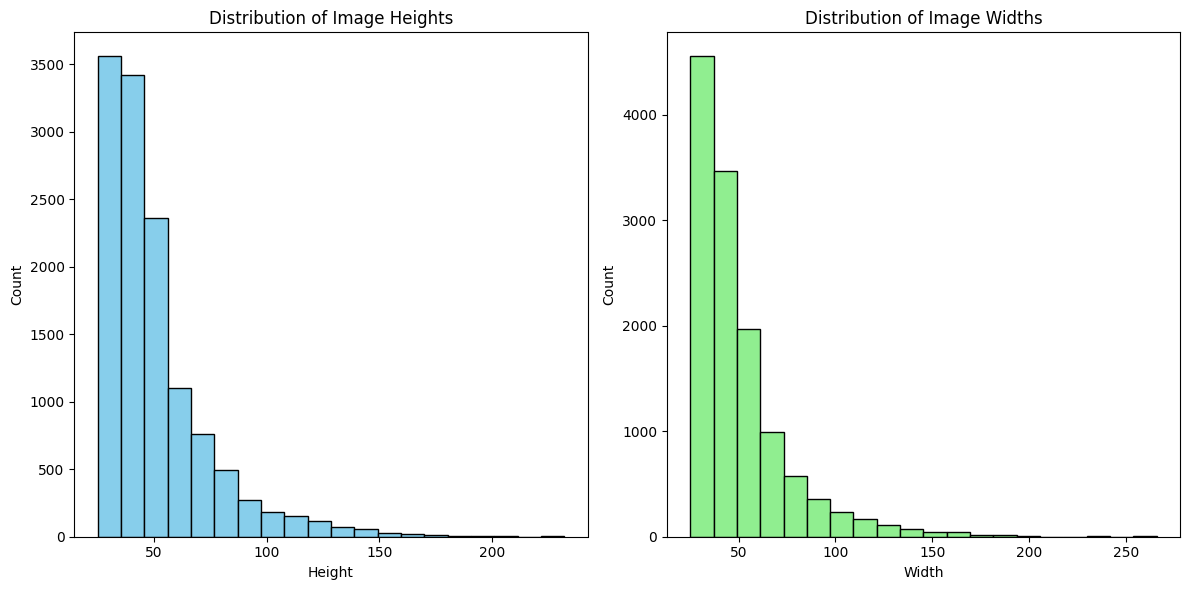

In [ ]:
# Initialize lists to store heights and widths
heights = []
widths = []

# Iterate over the .ppm image files
folder_path = "/content/data/test/gtsrb/GTSRB/Final_Test/Images"
for file_name in os.listdir(folder_path):
    if file_name.endswith(".ppm"):
        # Get the image size
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path)
        width, height = image.size
        widths.append(width)
        heights.append(height)

# Create a bar chart of heights
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(heights, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Height')
plt.ylabel('Count')
plt.title('Distribution of Image Heights')

# Create a bar chart of widths
plt.subplot(1, 2, 2)
plt.hist(widths, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Width')
plt.ylabel('Count')
plt.title('Distribution of Image Widths')

plt.tight_layout()
plt.show()

Distribution of the Image heights and widths show us that most of the images height and width are concentrated at around 30~50 pixels.
Therefore, we will be resizing all the images to 32x32 pixels

#### Distribution of the class frequencies

Class frequency distribution refers to the distribution of samples across different classes in a dataset. Class imbalance occurs when the number of samples in each class is significantly different, leading to an unequal representation of classes. This imbalance can impact the performance and accuracy of machine learning models, particularly in scenarios where the minority class is of interest.

In our case, there is an imbalance in the instances of training data.

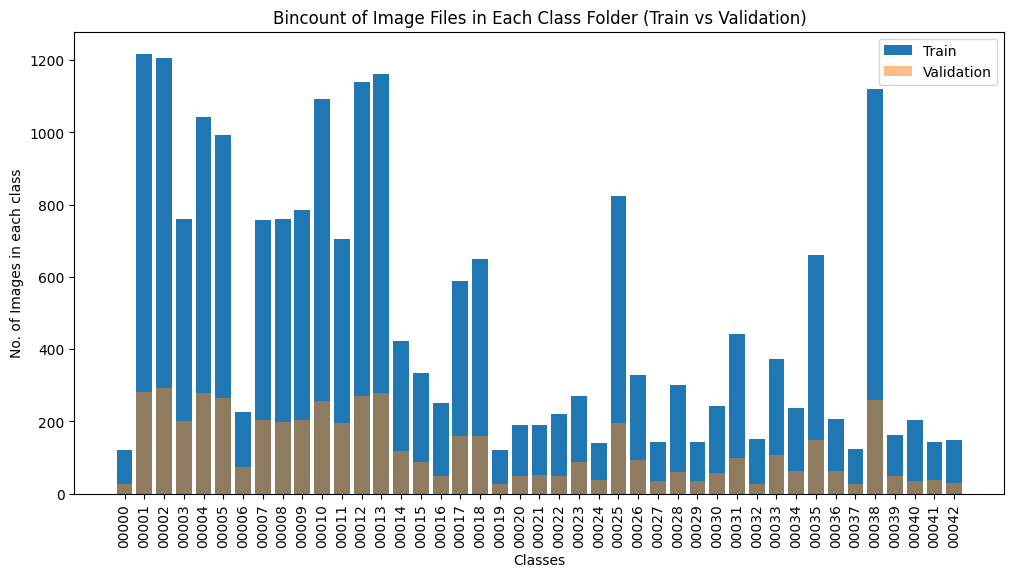

In [ ]:
ratio = 0.8
batch_size = 32

class_folders = sorted(dir_list)

# Split the dataset into train and validation sets
n_train_examples = int(len(train_dataset) * ratio)
n_val_examples = len(train_dataset) - n_train_examples

train_data, val_data = torch.utils.data.random_split(train_dataset, [n_train_examples, n_val_examples])

# Create dataloaders for train and validation sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)

# Calculate bincounts for training data
train_counts = [0] * len(class_folders)
for _, target in train_data:
    train_counts[target] += 1

# Calculate bincounts for validation data
val_counts = [0] * len(class_folders)
for _, target in val_data:
    val_counts[target] += 1

# Plotting the bincount for train and validation data
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(class_folders)), train_counts, label='Train')
plt.bar(np.arange(len(class_folders)), val_counts, label='Validation', alpha=0.5)
plt.xticks(np.arange(len(class_folders)), class_folders, rotation=90)
plt.xlabel("Classes")
plt.ylabel("No. of Images in each class")
plt.title("Bincount of Image Files in Each Class Folder (Train vs Validation)")
plt.legend()
plt.show()

In [ ]:
# No. of images in the training and Validation sets:
for idx, (tc, vc) in enumerate(zip(train_counts, val_counts)):
    print(f"For class {idx}: Training data = {tc}, Validation data = {vc}, Total = {tc+vc}")
    print("-"*80)

For class 0: Training data = 122, Validation data = 28, Total = 150
--------------------------------------------------------------------------------
For class 1: Training data = 1218, Validation data = 282, Total = 1500
--------------------------------------------------------------------------------
For class 2: Training data = 1206, Validation data = 294, Total = 1500
--------------------------------------------------------------------------------
For class 3: Training data = 760, Validation data = 200, Total = 960
--------------------------------------------------------------------------------
For class 4: Training data = 1042, Validation data = 278, Total = 1320
--------------------------------------------------------------------------------
For class 5: Training data = 994, Validation data = 266, Total = 1260
--------------------------------------------------------------------------------
For class 6: Training data = 227, Validation data = 73, Total = 300
--------------------------

#### Resampling:

Resampling is a technique used to address imbalanced datasets, where one class has significantly more samples than the others. Imbalanced datasets can pose challenges for machine learning models as they may be biased towards the majority class and have difficulty properly representing and predicting the minority class. Resampling methods aim to balance the class distribution, improving the model's ability to learn from and make accurate predictions on the minority class.

In [ ]:
class_dist = []
for tc,vc in zip(train_counts, val_counts):
  class_dist.append(tc+vc)

# print("No. of Images in each class: ", class_dist)

In [ ]:
train_class_freq =  {}
for i,j in zip(class_folders, class_dist):
  train_class_freq[i] = j

print("No. of Images in each class: ", train_class_freq)

No. of Images in each class:  {'00000': 150, '00001': 1500, '00002': 1500, '00003': 960, '00004': 1320, '00005': 1260, '00006': 300, '00007': 960, '00008': 960, '00009': 990, '00010': 1350, '00011': 900, '00012': 1410, '00013': 1440, '00014': 540, '00015': 420, '00016': 300, '00017': 750, '00018': 810, '00019': 150, '00020': 240, '00021': 240, '00022': 270, '00023': 360, '00024': 180, '00025': 1020, '00026': 420, '00027': 180, '00028': 360, '00029': 180, '00030': 300, '00031': 540, '00032': 180, '00033': 480, '00034': 300, '00035': 810, '00036': 270, '00037': 150, '00038': 1380, '00039': 210, '00040': 240, '00041': 180, '00042': 180}


There are two main strategies for resampling imbalanced datasets:
* Oversampling: Increase the number of minority class samples to match the majority class.
*Undersampling: Decrease the number of majority class samples to match the minority class.

We employ Oversampling here. This can be achieved by replicating existing samples or by generating synthetic samples

In [ ]:
from sklearn.utils import resample

In [ ]:
# Determine the majority class count
majority_class_count = max(train_class_freq.values())
print("Maximum no. of images in all the classes: ", majority_class_count)

Maximum no. of images in all the classes:  1500


In [ ]:
# Perform random oversampling on the training dataset
resampled_train_dataset = []
for cls, count in train_class_freq.items():
    if count < majority_class_count:
        # Oversample the minority classes
        minority_samples = [(img, label) for img, label in train_dataset if label == int(cls)]
        oversampled_samples = resample(minority_samples, replace=True, n_samples=majority_class_count, random_state=42)
        resampled_train_dataset.extend(oversampled_samples)
    else:
        # Keep the majority class samples as-is
        majority_samples = [(img, label) for img, label in train_dataset if label == int(cls)]
        resampled_train_dataset.extend(majority_samples)

In [ ]:
print("The total no. of images after resampling: ", len(resampled_train_dataset))

The total no. of images after resampling:  64500


In [ ]:
# Calculate the frequency of each class in the resampled training set
resampled_train_class_freq = collections.Counter([label for _, label in resampled_train_dataset])

# Sort the resampled class frequencies by class label
sorted_resampled_train_class_freq = sorted(resampled_train_class_freq.items())

# Separate the resampled class labels and frequencies
resampled_train_class_labels, resampled_train_frequencies = zip(*sorted_resampled_train_class_freq)


In [ ]:
resampled_train_class_freq

Counter({0: 1500,
         1: 1500,
         2: 1500,
         3: 1500,
         4: 1500,
         5: 1500,
         6: 1500,
         7: 1500,
         8: 1500,
         9: 1500,
         10: 1500,
         11: 1500,
         12: 1500,
         13: 1500,
         14: 1500,
         15: 1500,
         16: 1500,
         17: 1500,
         18: 1500,
         19: 1500,
         20: 1500,
         21: 1500,
         22: 1500,
         23: 1500,
         24: 1500,
         25: 1500,
         26: 1500,
         27: 1500,
         28: 1500,
         29: 1500,
         30: 1500,
         31: 1500,
         32: 1500,
         33: 1500,
         34: 1500,
         35: 1500,
         36: 1500,
         37: 1500,
         38: 1500,
         39: 1500,
         40: 1500,
         41: 1500,
         42: 1500})

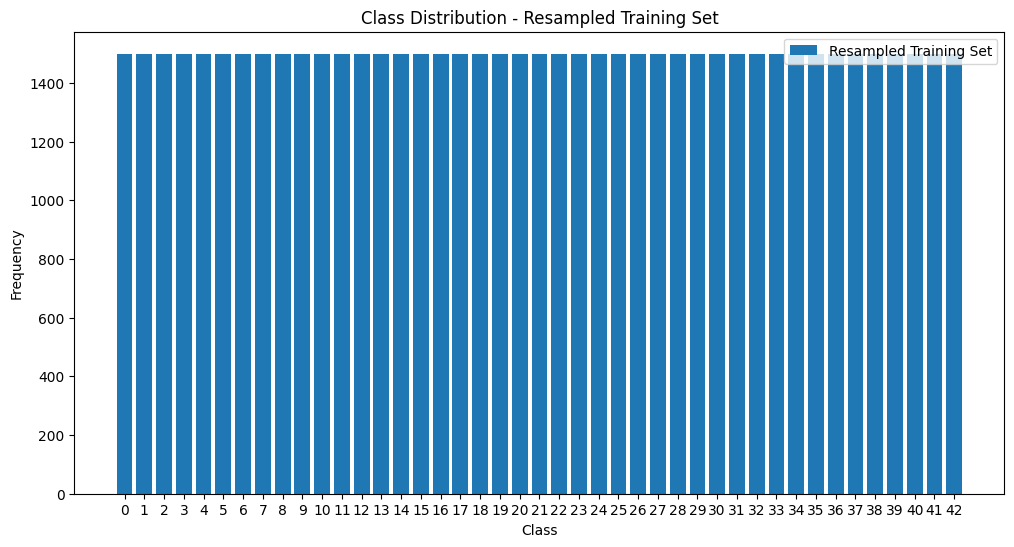

In [ ]:
# Plot the class distribution for the resampled training set
plt.figure(figsize=(12, 6))
plt.bar(resampled_train_class_labels, resampled_train_frequencies, label='Resampled Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution - Resampled Training Set')
plt.xticks(resampled_train_class_labels)
plt.legend()
plt.show()

## DataLoaders & DataBlock

In [ ]:
gtsrb = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_y=parent_label,
                  item_tfms=Resize(128))

In [ ]:
path = "/content/data/train/gtsrb/GTSRB/Training"

In [ ]:
dls = gtsrb.dataloaders(path)

In [ ]:
print("No. of classes: ", dls.c)

No. of classes:  43


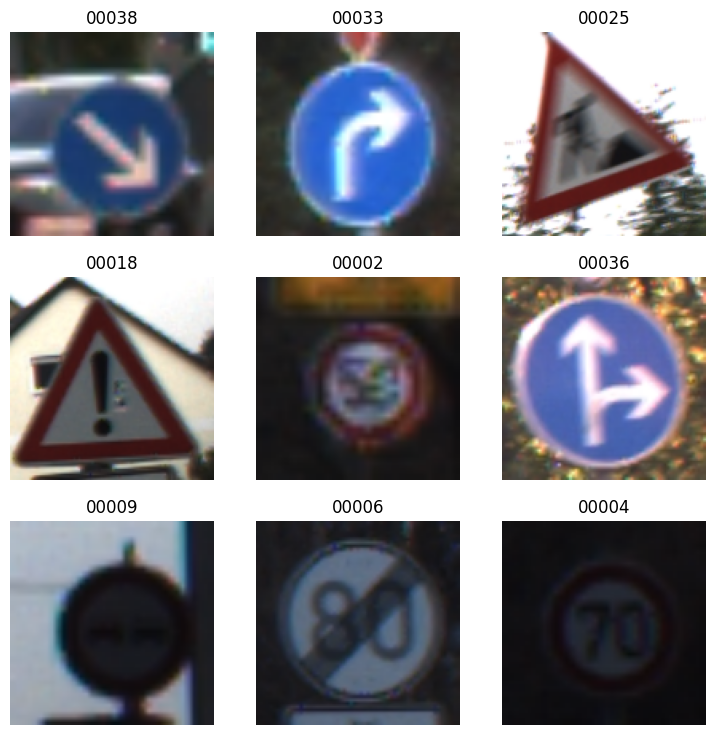

In [ ]:
dls.show_batch()

In [ ]:
# dls.valid.show_batch(max_n=8, nrows=2)

In [ ]:
# dls.train.show_batch(max_n=8, nrows=2)

"CrossEntropyLossFlat()" is suitable for loss function considering multiclass classification as it combines softmax activation and cross-entropy loss efficiently. It takes logits as input, applies softmax internally, and computes cross-entropy loss with target labels.



Common metrics for multiclass classification include accuracy (overall correctness), ROC AUC (quality of predicted probabilities), precision (precision of positive predictions), and recall (ability to identify positive samples).

In [ ]:
# Create the learner using vision_learner
learn = vision_learner(
    dls=dls,
    arch=resnet34,
    pretrained=True,
    loss_func=CrossEntropyLossFlat(),
    metrics=[
        accuracy,
        error_rate,
        RocAuc(average='macro'),
        Recall(average='macro'),
        Precision(average='macro'),
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 93.6MB/s]


For learning rates, we are using the “lr_find()” to find us a good learning rate, which uses the the valley algorithm to give a good learning rate. In general, the order of algorithms for finding good learnining rate ⇒ Valley > Slide > Steep > Minimum

SuggestedLRs(valley=0.001737800776027143)

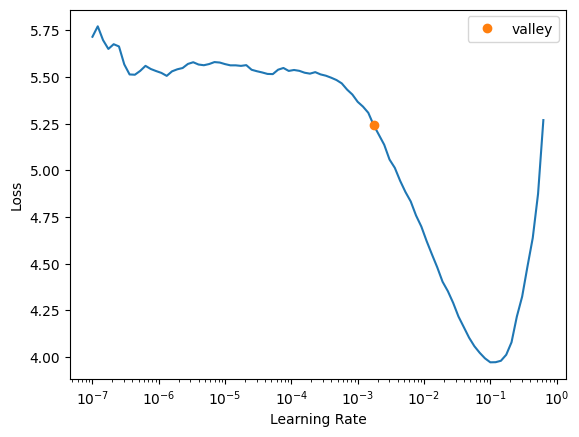

In [ ]:
learning_rate = learn.lr_find()
learning_rate

In [ ]:
print("Optimal learning rate: ", learning_rate[0])

Optimal learning rate:  0.001737800776027143


In [ ]:
learn.summary()

Sequential (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 64 x 64   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 32 x 32   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Train the model
learn.fit_one_cycle(5, learning_rate[0])

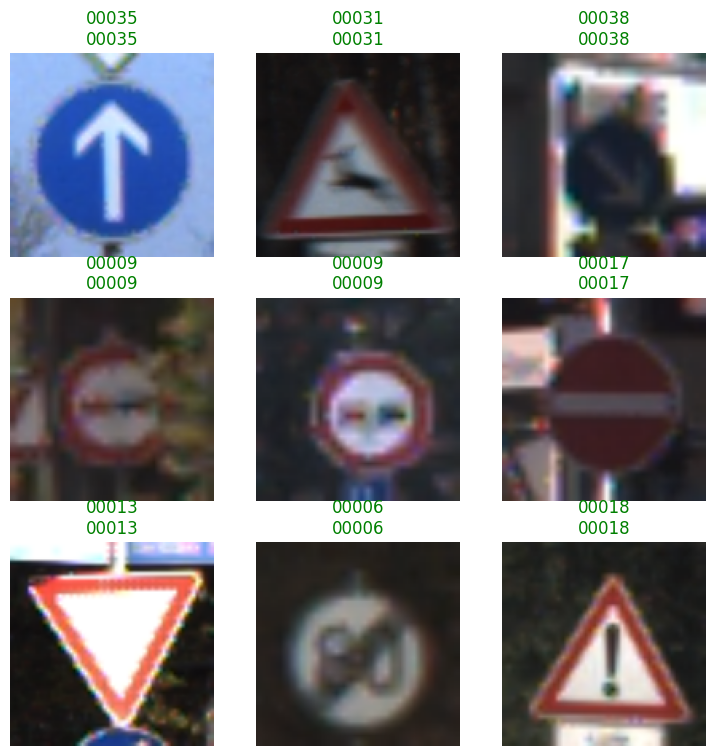

In [ ]:
learn.show_results()

## Confusion Matrix

The confusion matrix shows the number of samples that were incorrectly classified. By examining the off-diagonal elements of the matrix, you can identify specific classes that are often confused with each other, indicating the types of misclassifications occurring.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

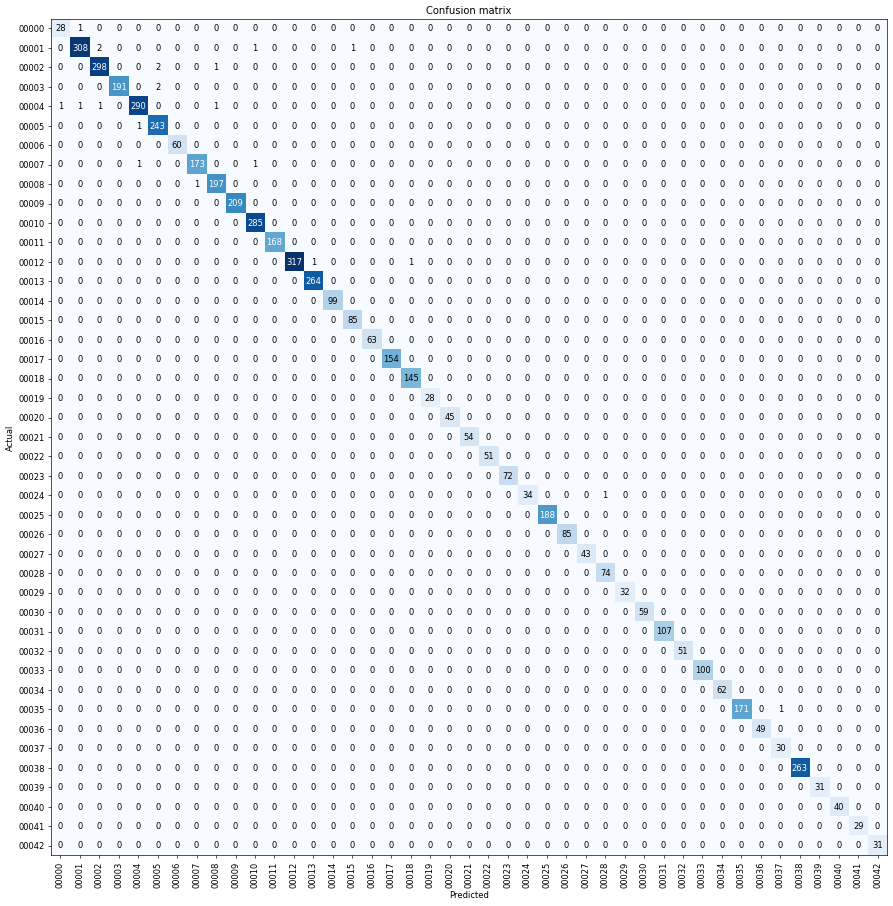

In [ ]:
interp.plot_confusion_matrix(figsize=(15,15),dpi=60)

In [ ]:
interp.most_confused(min_val=3)

[]

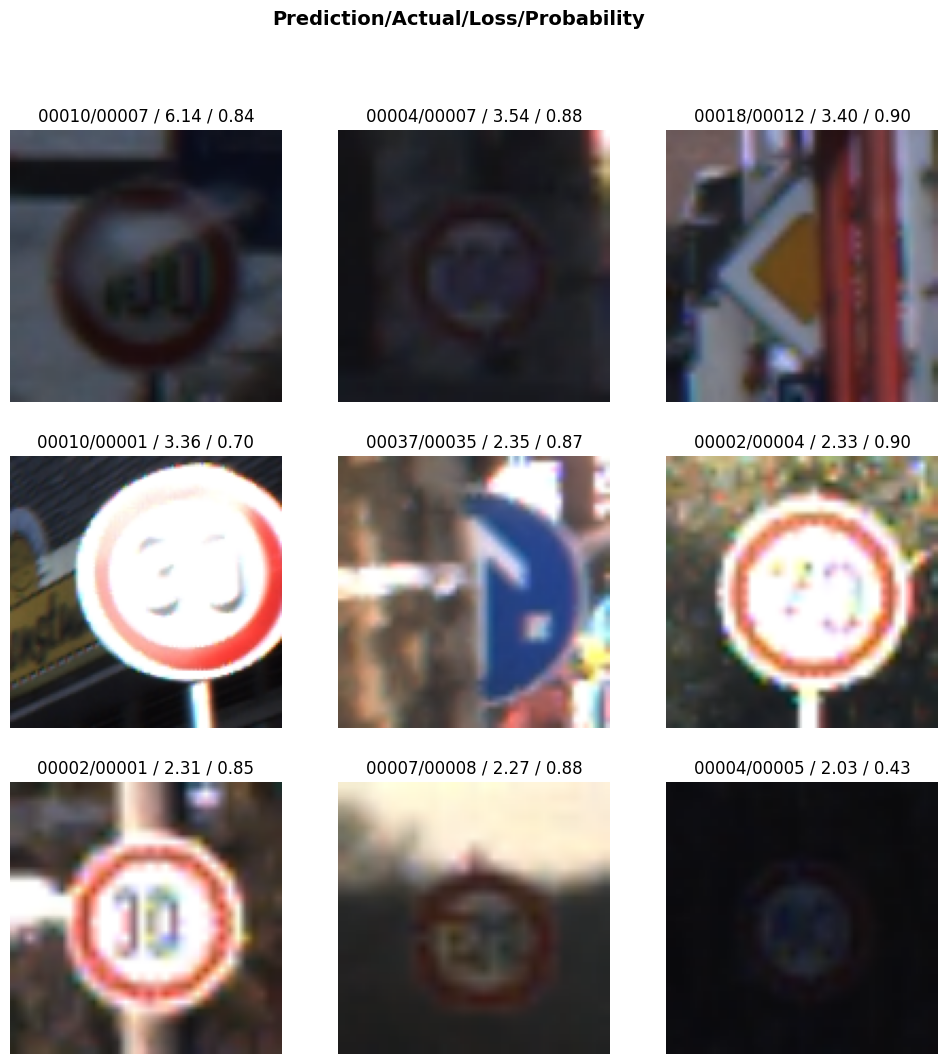

In [ ]:
interp.plot_top_losses(9, figsize= (12,12))

Reasons for Misclassifications:

* If the training dataset does not adequately represent the variability and complexity of the real-world data, the classifier may struggle to generalize to new examples and make incorrect predictions. Some of the training data in our case is pixelated and has a dark background (which we have tried to rectify by increasing the "lighting" parameter in data Augmentation). Thus, a presence of noisy or outlier data points in the training or test set can disrupt the learning process and cause incorrect predictions.

## Folder for storing models

In [ ]:
model_PATH = "/content/models"

In [ ]:
if not os.path.exists(model_PATH):
   os.makedirs(model_PATH)

# Specify the path to save the model
model_path = os.path.join(model_PATH, "traffic_sign_classifier_pretrained.pth")

# Save the trained model
learn.export(model_path)

# Print the path where the model is saved
print("Model saved at:", model_path)

Model saved at: /content/models/traffic_sign_classifier_pretrained.pth


## Load the model for prediction

In [ ]:
new_model = load_learner('/content/models/traffic_sign_classifier_pretrained.pth')

## Prediction and Accuracy check

Just to show: Prediction of 117th image on the testing set

In [ ]:
new_model.predict(
    item='/content/data/test/gtsrb/GTSRB/Final_Test/Images/00117.ppm'
)

('00025',
 tensor(25),
 tensor([2.7293e-05, 6.8614e-04, 3.1293e-06, 3.9423e-05, 9.0134e-07, 7.4684e-07,
         1.3180e-04, 7.8742e-06, 1.5407e-05, 1.2373e-05, 3.5723e-06, 2.2527e-05,
         1.6262e-03, 6.8700e-05, 1.7041e-05, 8.7789e-05, 8.9966e-06, 4.3659e-05,
         9.1003e-04, 7.3163e-05, 8.0461e-05, 1.0956e-04, 7.4050e-02, 3.2581e-04,
         1.9720e-02, 8.6739e-01, 1.4602e-03, 4.4065e-05, 5.5673e-03, 9.6740e-04,
         3.7726e-03, 2.2383e-02, 2.1435e-05, 2.6524e-06, 7.0238e-06, 1.2925e-06,
         1.2494e-04, 1.5764e-05, 2.5608e-06, 3.2734e-05, 7.4035e-05, 1.8328e-05,
         4.6134e-05]))

In [ ]:
import shutil
shutil.move('/content/data/test/gtsrb/GTSRB/Final_Test/Images/GT-final_test.test.csv', '/content/data/test/gtsrb/GTSRB/GT-final_test.test.csv')

'/content/data/test/gtsrb/GTSRB/GT-final_test.test.csv'

In [ ]:
TESTSET_PATH = "/content/data/test/gtsrb/GTSRB/Final_Test/Images"

test_image_set = []
for images in os.listdir(TESTSET_PATH):
  img_path = f"{TESTSET_PATH}/{images}"
  test_image_set.append(img_path)

test_image_set = sorted(test_image_set)

<Axes: >

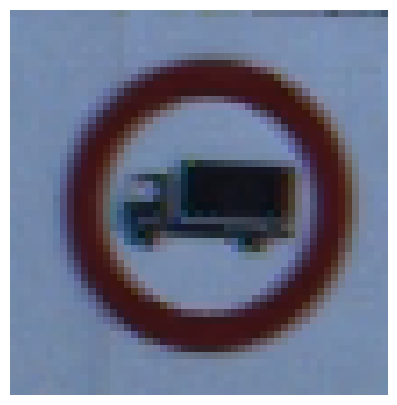

In [ ]:
img_fn = test_image_set[0]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [ ]:
dl = new_model.dls.test_dl(test_image_set)

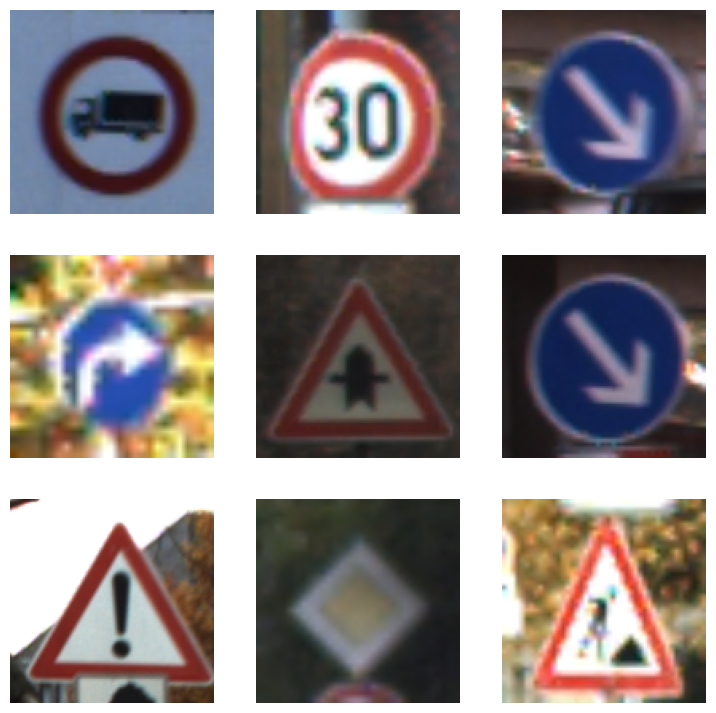

In [ ]:
dl.show_batch()

#### Batch Prediction

In [ ]:
def predict(model, dl):
  preds = model.get_preds(dl, with_decoded=True)
  out = preds[2]
  return out

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

def get_accuracy(predicted, actual):
  # Compute accuracy
  accuracy = accuracy_score(actual, predicted)
  return accuracy

In [ ]:
preds = new_model.get_preds(dl=dl, with_decoded=True)
preds[2]

tensor([16,  1, 38,  ...,  6,  7, 10])

In [ ]:
print("The predicted tensors are: ", preds[2])

The predicted tensors are:  tensor([16,  1, 38,  ...,  6,  7, 10])


In [ ]:
# Get training accuracy
train_acc_pretrained = learn.validate()[1]
print(f"The training accuracy is: {train_acc_pretrained}")

The training accuracy is: 0.9958708882331848


#### Load the Test CSV and extract the correct classes for test Images

In [ ]:
with open("/content/data/test/gtsrb/GT-final_test.csv") as f:
    reader = csv.reader(f, delimiter=';')
    next(reader) # skip header

    y = []
    # loop over all images in current annotations file
    for row in reader:
        filename = row[0] # filename is in the 0th column
        label = int(row[7]) # label is in the 7th column
        y.append(label)

print(y)

[16, 1, 38, 33, 11, 38, 18, 12, 25, 35, 12, 7, 23, 7, 4, 9, 21, 20, 27, 38, 4, 33, 9, 3, 1, 11, 13, 10, 9, 11, 5, 17, 34, 23, 2, 17, 3, 12, 16, 8, 7, 30, 18, 12, 24, 25, 3, 10, 18, 8, 25, 13, 15, 9, 13, 35, 5, 26, 9, 16, 38, 10, 4, 9, 15, 9, 26, 2, 5, 28, 11, 25, 30, 34, 5, 12, 1, 10, 25, 25, 21, 33, 25, 7, 10, 35, 3, 7, 22, 13, 3, 1, 2, 14, 12, 32, 3, 38, 9, 33, 1, 10, 5, 11, 33, 4, 35, 25, 33, 4, 1, 14, 16, 10, 30, 3, 27, 29, 1, 17, 13, 7, 1, 8, 2, 10, 10, 30, 1, 6, 36, 3, 14, 13, 11, 10, 18, 40, 2, 38, 41, 4, 6, 18, 17, 25, 2, 41, 11, 21, 7, 24, 11, 25, 17, 3, 6, 9, 7, 4, 13, 16, 4, 25, 18, 9, 13, 14, 29, 17, 13, 38, 26, 25, 33, 1, 3, 40, 13, 2, 8, 4, 36, 25, 20, 25, 18, 1, 10, 8, 10, 29, 12, 38, 31, 2, 8, 38, 18, 28, 17, 9, 4, 1, 17, 9, 2, 31, 13, 15, 15, 38, 25, 5, 25, 13, 10, 5, 4, 10, 2, 4, 5, 1, 14, 12, 12, 5, 8, 36, 25, 13, 33, 18, 33, 19, 12, 30, 4, 18, 12, 13, 20, 0, 10, 40, 5, 8, 12, 38, 20, 14, 0, 36, 34, 28, 35, 13, 25, 15, 35, 14, 18, 25, 1, 12, 5, 25, 2, 18, 18, 18, 34,

In [ ]:
## Convert the list to tensors:
y = torch.Tensor(y)
y

tensor([16.,  1., 38.,  ...,  6.,  7., 10.])

In [ ]:
test_acc_pretrained = get_accuracy(preds[2], y)
print("The accuracy for ResNet34 (Pretrained) is: ", test_acc_pretrained)

NameError: ignored

## MODELS - study of different architechures like ResNet18, ResNet34, ResNet50 and our own architecture (TrafficSignClassifier)

#### Randomly initialized weights:

In [ ]:
learn = vision_learner(
    dls=dls,
    arch=models.resnet34,
    pretrained=False,
    loss_func=CrossEntropyLossFlat(),
    metrics=[
        accuracy,
        error_rate,
        RocAuc(average='macro'),
        Recall(average='macro'),
        Precision(average='macro'),
    ]
)

SuggestedLRs(valley=0.0004786300996784121)

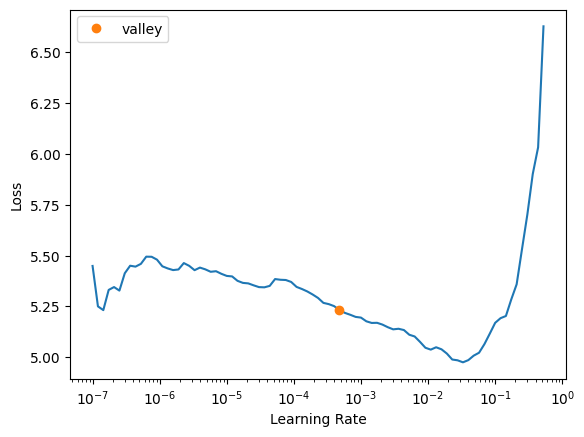

In [ ]:
learning_rate = learn.lr_find()
learning_rate

In [ ]:
print("Optimal learning rate: ", learning_rate[0])

Optimal learning rate:  0.0004786300996784121


In [ ]:
learn.summary()

Sequential (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 64 x 64   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 32 x 32   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Train the model
learn.fit_one_cycle(5, learning_rate[0])

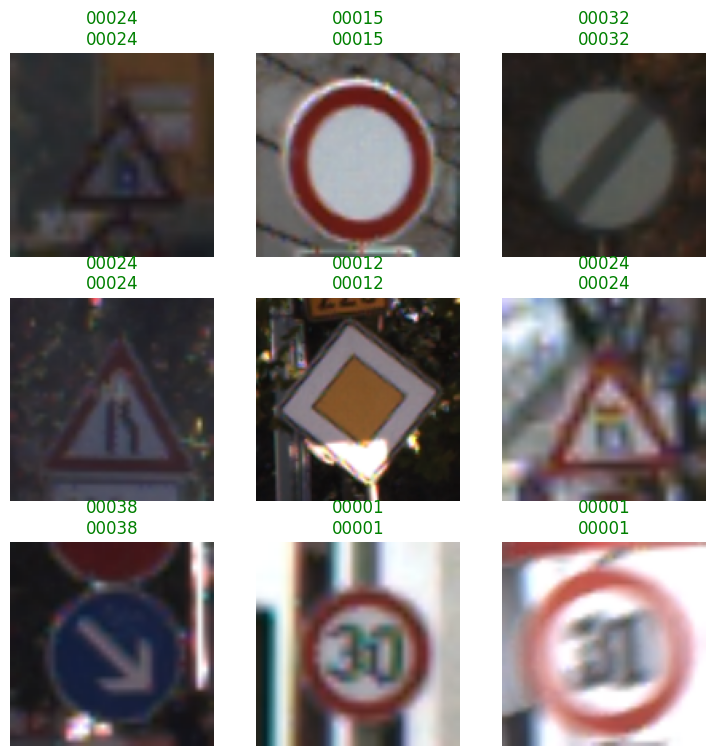

In [ ]:
learn.show_results()

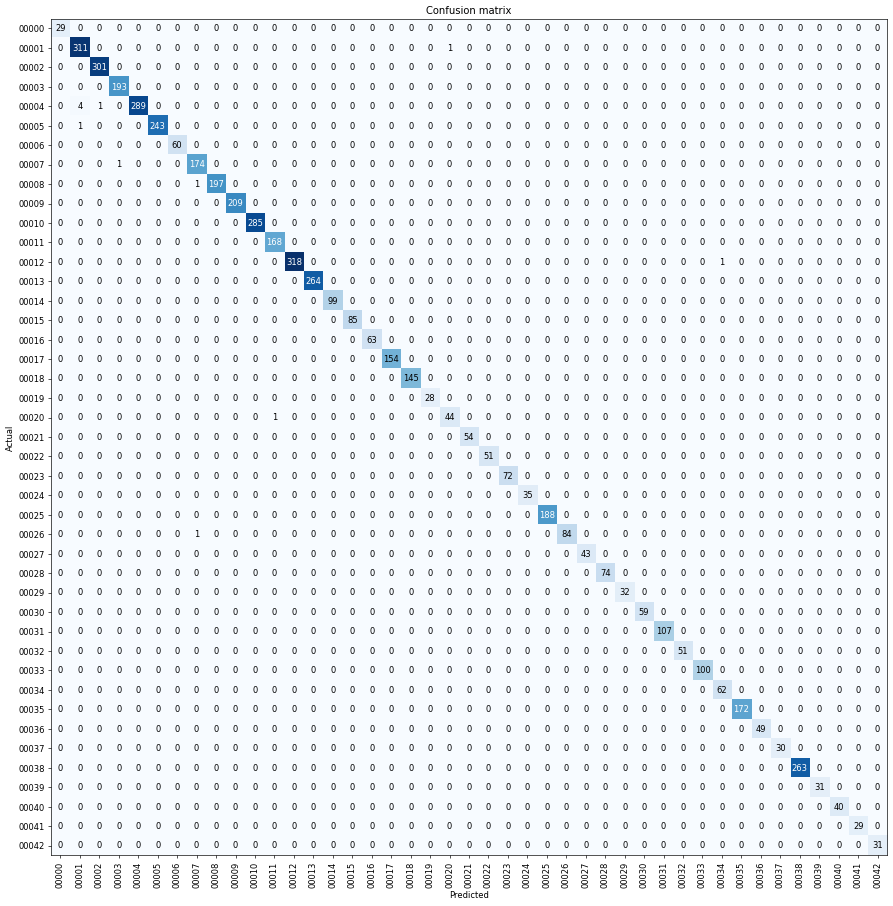

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(15,15),dpi=60)

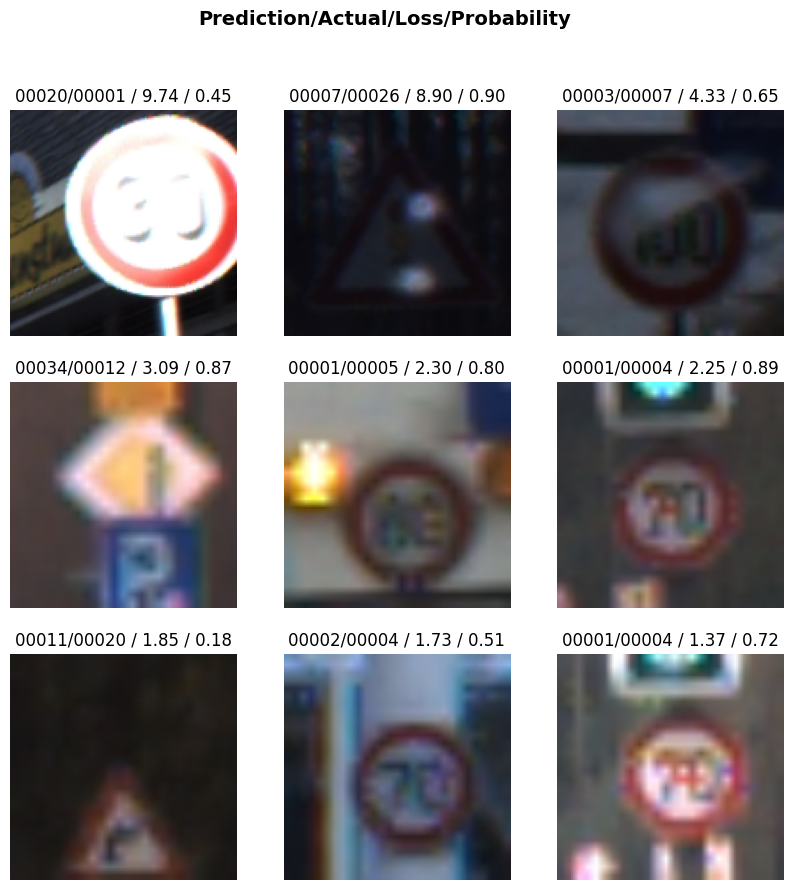

In [ ]:
interp.plot_top_losses(9, figsize= (10,10))

In [ ]:
train_acc_randomIni = learn.validate()[1]
print(f"The training accuracy is: {train_acc_randomIni}")

The training accuracy is: 0.9977477192878723


In [ ]:
if not os.path.exists(model_PATH):
   os.makedirs(model_PATH)

# Specify the path to save the model
model_path = os.path.join(model_PATH, "traffic_sign_classifier_randomIni.pth")

# Save the trained model
learn.export(model_path)

# Print the path where the model is saved
print("Model saved at:", model_path)

Model saved at: /content/models/traffic_sign_classifier_randomIni.pth


In [ ]:
new_model2=load_learner('/content/models/traffic_sign_classifier_randomIni.pth')

In [ ]:
dl = new_model2.dls.test_dl(test_image_set)

In [ ]:
predictions = new_model2.get_preds(dl=dl, with_decoded=True)
predictions[2]

tensor([16,  1, 38,  ...,  5,  7, 10])

In [ ]:
test_acc_randomIni = get_accuracy(predictions[2], y)
print("The accuracy for ResNet34 (Randomly initialized) is: ", test_acc_randomIni)

The accuracy for ResNet34 (Randomly initialized) is:  0.9571654790182106


We performed more and got consistent results i.e. test accuracy of more than 95%. We also noted that ResNet34 with randomly initialized weights gave better acuracy in all the runs, compared to Pretrained model.

### Building our own CNN module

In [ ]:
import torch.nn as nn

class TrafficSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignClassifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
# Step 3: Create a Learner and train the model
model = TrafficSignClassifier(num_classes=43)

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10)

In [ ]:
learn.summary()

TrafficSignClassifier (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 128 x 128 
Conv2d                                    896        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 64 x 64   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 64 x 64   
Conv2d                                    18496      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 32 x 32   
MaxPool2d                                                      
____________________________________________________________________________
                    

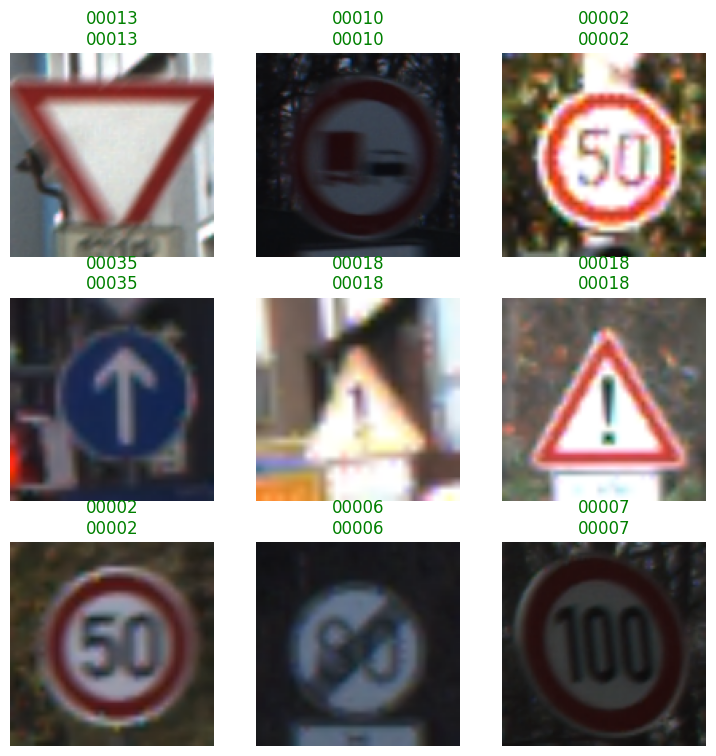

In [ ]:
learn.show_results()

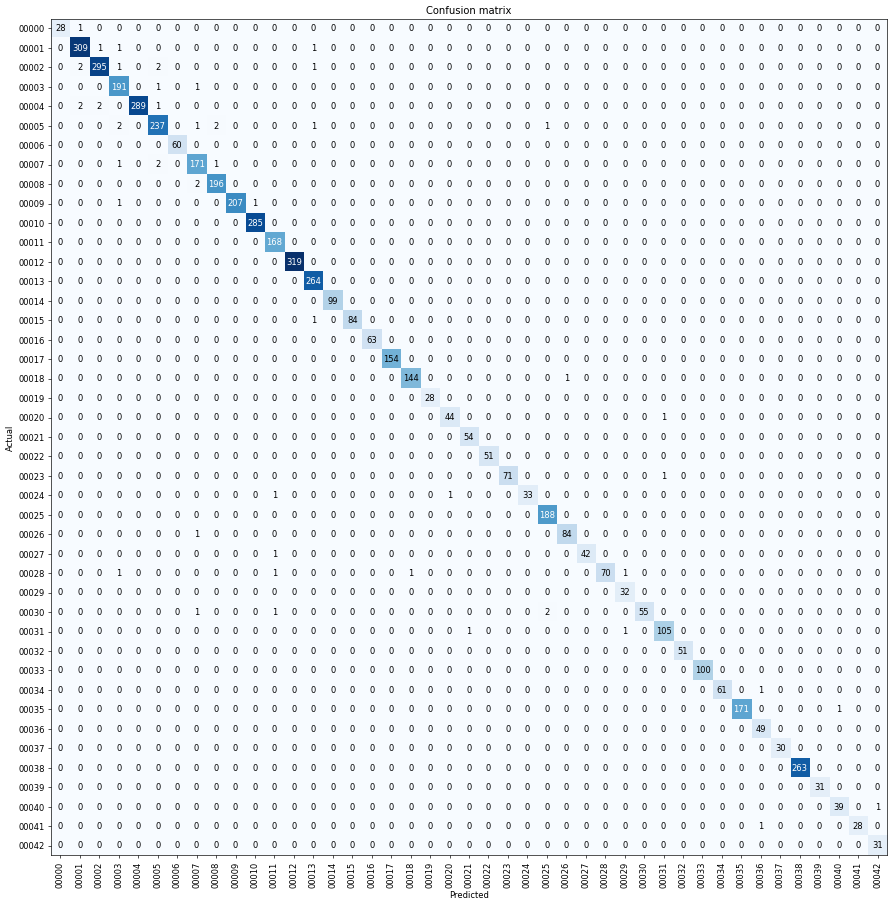

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(15,15),dpi=60)

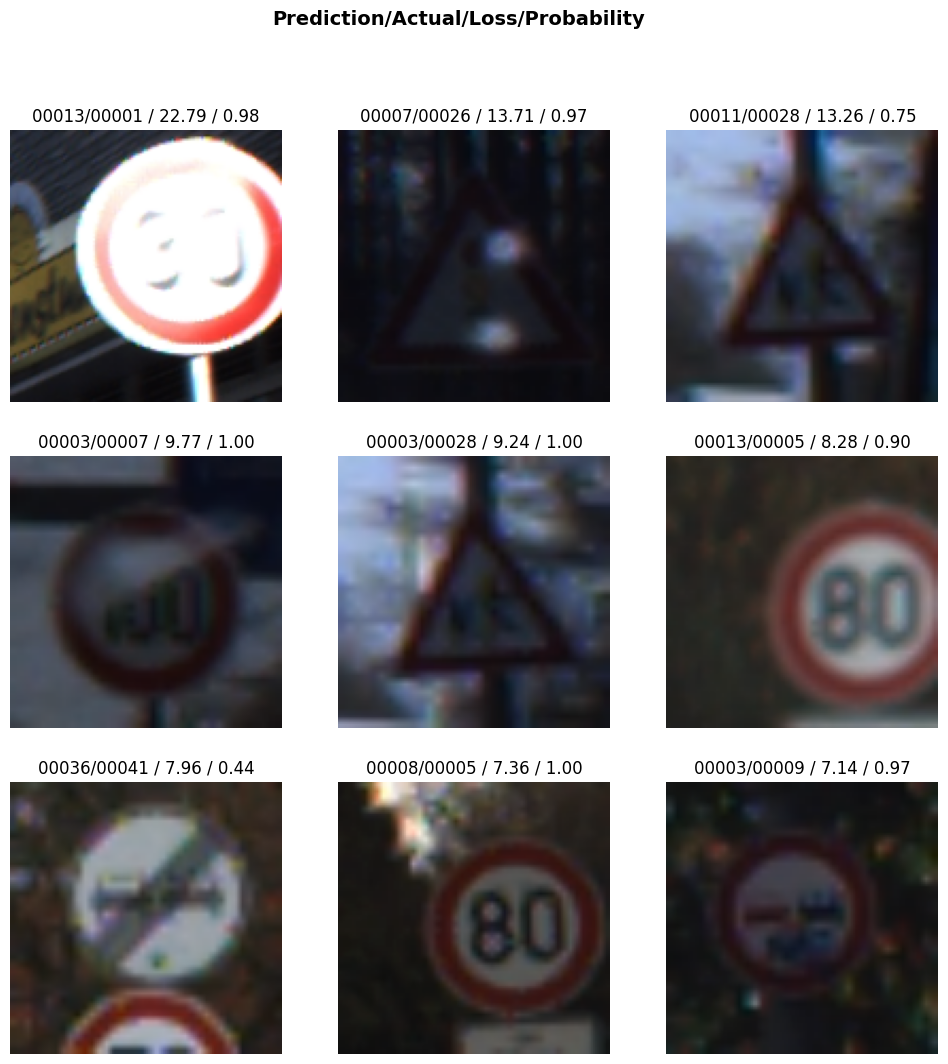

In [ ]:
interp.plot_top_losses(9, figsize= (12,12))

In [ ]:
train_acc_ourModel = learn.validate()[1]
print(f"The training accuracy is: {train_acc_ourModel}")

The training accuracy is: 0.9898648858070374


In [ ]:
if not os.path.exists(model_PATH):
   os.makedirs(model_PATH)

# Specify the path to save the model
model_path = os.path.join(model_PATH, "traffic_sign_classifier_OurModel.pth")

# Save the trained model
learn.export(model_path)

# Print the path where the model is saved
print("Model saved at:", model_path)

Model saved at: /content/models/traffic_sign_classifier_OurModel.pth


In [ ]:
new_model3=load_learner('/content/models/traffic_sign_classifier_OurModel.pth')

In [ ]:
dl = new_model3.dls.test_dl(test_image_set)

In [ ]:
OurModel_preds = new_model3.get_preds(dl=dl, with_decoded=True)
OurModel_preds[2]

tensor([16,  1, 38,  ..., 38,  7, 10])

In [ ]:
test_acc_ourModel = get_accuracy(OurModel_preds[2], y)
print("The accuracy for the CNN architechture built by us is: ", test_acc_ourModel)

The accuracy for the CNN architechture built by us is:  0.850356294536817


### Study of different architechture on batch size = 64

In [ ]:
train_dict = {
    'resnet_pretrained': train_acc_pretrained,
    'resnet_randomIni': train_acc_randomIni,
    'our Model': train_acc_ourModel
}

test_dict = {
    'resnet_pretrained': test_acc_pretrained,
    'resnet_randomIni': test_acc_randomIni,
    'our Model': test_acc_ourModel
}

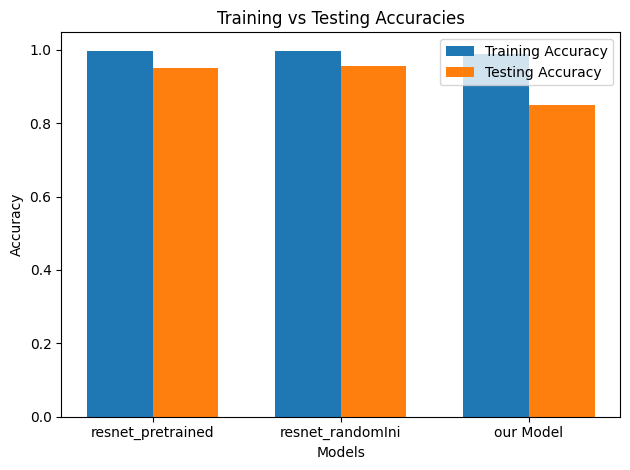

In [ ]:
models = list(train_dict.keys())

train_acc = [train_dict[model] for model in models]
test_acc = [test_dict[model] for model in models]

bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, train_acc, bar_width, label='Training Accuracy')
plt.bar(index + bar_width, test_acc, bar_width, label='Testing Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracies')
plt.xticks(index + bar_width/2, models)  # Set the x-ticks at the center of each group of bars
plt.legend()

plt.tight_layout()
plt.show()

### Study of BATCH SIZES on ResNet34 model

Considering batch sizes of 16, 32, 64 on Randomly Initialised ResNet Model

###### 1. For batch_size = 16

Training

In [ ]:
dls = gtsrb.dataloaders(path, bs=16)

In [ ]:
learn = vision_learner(
    dls=dls,
    arch=resnet34,
    pretrained=False,
    loss_func=CrossEntropyLossFlat(),
    metrics=[
        accuracy,
        error_rate,
        RocAuc(average='macro'),
        Recall(average='macro'),
        Precision(average='macro'),
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SuggestedLRs(valley=0.0008317637839354575)

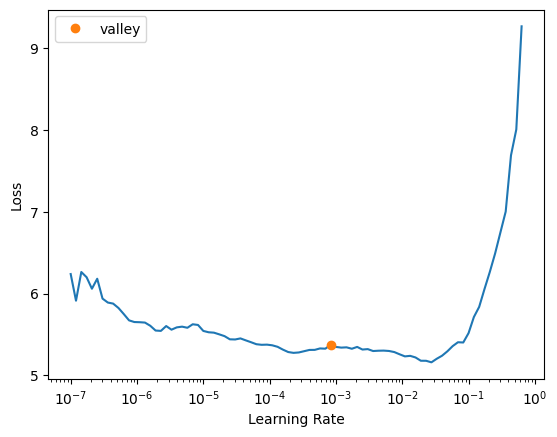

In [ ]:
learning_rate = learn.lr_find()
learning_rate

In [ ]:
print("Optimal learning rate: ", learning_rate[0])

Optimal learning rate:  0.0008317637839354575


In [ ]:
learn.fit_one_cycle(5, learning_rate[0])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bs16_TrainAcc = learn.validate()[1]
print(f"The training accuracy with batch size 16 is: {bs16_TrainAcc}")

The training accuracy with batch size 16 is: 0.9975600838661194


In [ ]:
if not os.path.exists(model_PATH):
   os.makedirs(model_PATH)

# Specify the path to save the model
model_path = os.path.join(model_PATH, "bs16.pth")

# Save the trained model
learn.export(model_path)

# Print the path where the model is saved
print("Model saved at:", model_path)

Model saved at: /content/models/bs16.pth


Testing

In [ ]:
bs16_model=load_learner('/content/models/bs16.pth')

In [ ]:
dl = bs16_model.dls.test_dl(test_image_set)

In [ ]:
bs16_predictions = bs16_model.get_preds(dl=dl, with_decoded=True)
bs16_predictions[2]

tensor([16,  1, 38,  ...,  5,  7, 10])

In [ ]:
bs16_TestAcc = get_accuracy(bs16_predictions[2], y)
print("The test Accuracy with Batch size 16 is: ", bs16_TestAcc)

The test Accuracy with Batch size 16 is:  0.9718923198733175


###### 2. For batch size = 32

Training:

In [ ]:
dls = gtsrb.dataloaders(path, bs=32)

In [ ]:
learn = vision_learner(
    dls=dls,
    arch=resnet34,
    pretrained=False,
    loss_func=CrossEntropyLossFlat(),
    metrics=[
        accuracy,
        error_rate,
        RocAuc(average='macro'),
        Recall(average='macro'),
        Precision(average='macro'),
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SuggestedLRs(valley=0.0006918309954926372)

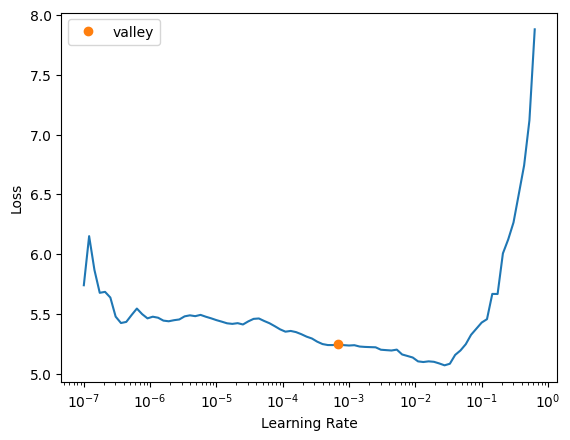

In [ ]:
learning_rate = learn.lr_find()
learning_rate

In [ ]:
print("Optimal learning rate: ", learning_rate[0])

Optimal learning rate:  0.0006918309954926372


In [ ]:
learn.fit_one_cycle(5, learning_rate[0])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bs32_TrainAcc = learn.validate()[1]
print(f"The training accuracy with batch size 32 is: {bs32_TrainAcc}")

The training accuracy with batch size 32 is: 0.9984984993934631


In [ ]:
if not os.path.exists(model_PATH):
   os.makedirs(model_PATH)

# Specify the path to save the model
model_path = os.path.join(model_PATH, "bs32.pth")

# Save the trained model
learn.export(model_path)

# Print the path where the model is saved
print("Model saved at:", model_path)

Model saved at: /content/models/bs32.pth


Testing:

In [ ]:
bs32_model=load_learner('/content/models/bs32.pth')

In [ ]:
dl = bs32_model.dls.test_dl(test_image_set)

In [ ]:
bs32_predictions = bs32_model.get_preds(dl=dl, with_decoded=True)
bs32_predictions[2]

tensor([16,  1, 38,  ...,  6,  7, 10])

In [ ]:
bs32_TestAcc = get_accuracy(bs32_predictions[2], y)
print("The test accuracy for batch size 32 is: ", bs32_TestAcc)

The test accuracy for batch size 32 is:  0.9765637371338084


###### 3. For batch size = 64

Since batch size of 64 is taken as default by Fastai during the training loop, this was done earlier. Hence we will not repeat here but take the accuracies from the earlier training

COMPARISON OF BATCH SIZES:

In [ ]:
batch_size_TrainAcc = {
    '16': bs16_TrainAcc,
    '32': bs32_TrainAcc,
    '64': train_acc_randomIni
}

batch_size_TestAcc = {
    '16': bs16_TestAcc,
    '32': bs32_TestAcc,
    '64': test_acc_randomIni
}

for bs in batch_size_TrainAcc:
  print(f"The testing accuracy for Batch size {bs} is: ", batch_size_TrainAcc[bs])

print("\n")

for bs in batch_size_TestAcc:
  print(f"The testing accuracy for Batch size {bs} is: ", batch_size_TestAcc[bs])

The testing accuracy for Batch size 16 is:  0.9975600838661194
The testing accuracy for Batch size 32 is:  0.9973723888397217
The testing accuracy for Batch size 64 is:  0.9977477192878723


The testing accuracy for Batch size 16 is:  0.9718923198733175
The testing accuracy for Batch size 32 is:  0.9771179730799683
The testing accuracy for Batch size 64 is:  0.9571654790182106


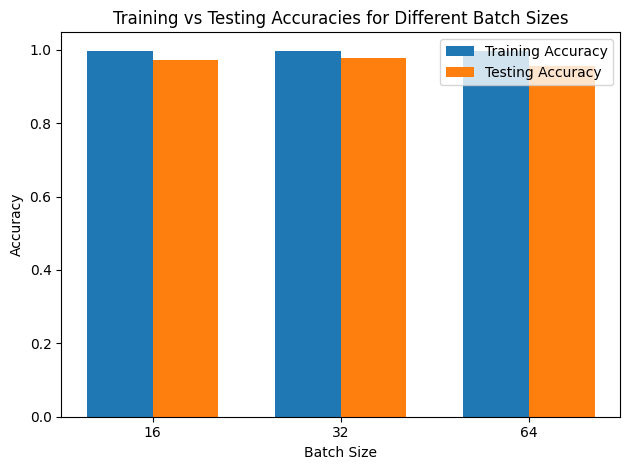

In [ ]:
batch_sizes = list(batch_size_TrainAcc.keys())

train_acc = [batch_size_TrainAcc[bs] for bs in batch_sizes]
test_acc = [batch_size_TestAcc[bs] for bs in batch_sizes]

bar_width = 0.35
index = np.arange(len(batch_sizes))

plt.bar(index, train_acc, bar_width, label='Training Accuracy')
plt.bar(index + bar_width, test_acc, bar_width, label='Testing Accuracy')

plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracies for Different Batch Sizes')
plt.xticks(index + bar_width/2, batch_sizes)
plt.legend()

plt.tight_layout()
plt.show()

Looks like for the Randomly initialised ResNet34 model, batch size of 32 works great since it gives better training accuracy.
Order: 32 > 16 > 64 (for ResNet34: Randomly Initialised)

### Training with Resampled data:

In [ ]:
# Create a new DataLoader with the resampled training dataset
resampled_train_loader = torch.utils.data.DataLoader(resampled_train_dataset, batch_size=32,shuffle=True)
resampled_train_loader

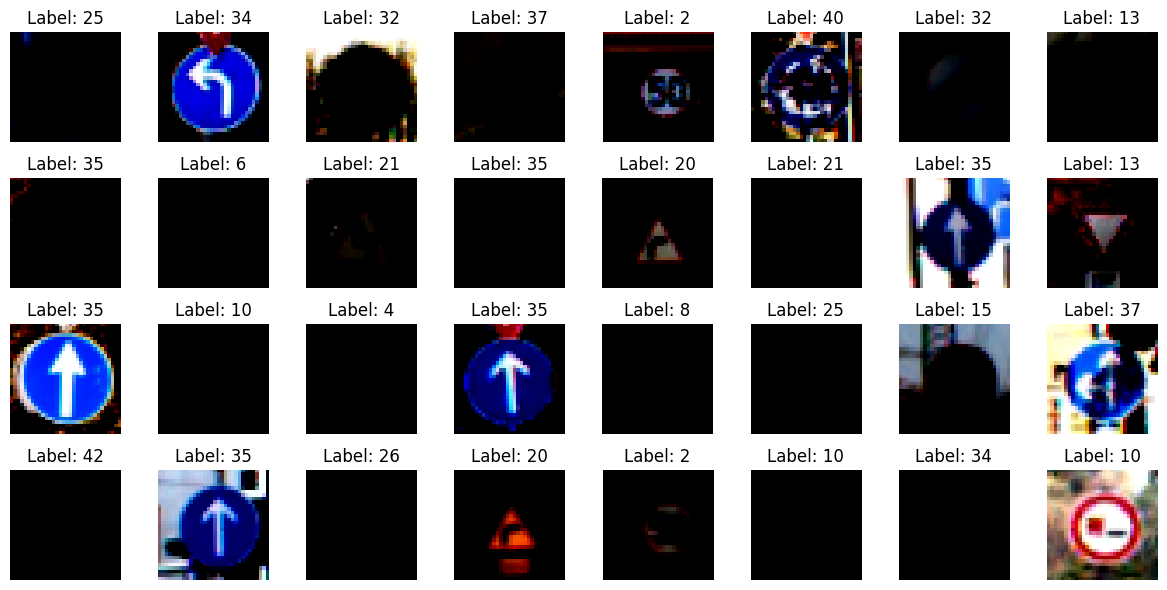

In [ ]:
# Get a batch of samples from the resampled training loader
batch = next(iter(resampled_train_loader))

# Unpack the batch into images and labels
images, labels = batch

# Plot the images in the batch
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i in range(4):
    for j in range(8):
        ax = axs[i, j]
        ax.imshow(images[8*i+j].permute(1, 2, 0))  # Transpose image tensor from (C, H, W) to (H, W, C)
        ax.axis('off')
        ax.set_title(f'Label: {labels[8*i+j]}')
plt.tight_layout()
plt.show()

In [ ]:
# Replace the training dataloader with the resampled one
learn.dls.train = resampled_train_loader

In [ ]:
# Define a custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
# Create a custom dataset
custom_dataset = CustomDataset(resampled_train_dataset)

In [ ]:
# Create a DataLoader for the custom dataset
dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=32, shuffle=True)

In [ ]:
# Create a DataLoaders object
dls = DataLoaders.from_dsets(custom_dataset, custom_dataset, device=torch.device("cuda"))

In [ ]:
# Define the loss function
loss_func = nn.CrossEntropyLoss()

# Create a Learner
learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)

In [ ]:
# Train the model
learn.fit_one_cycle(5)

In [ ]:
resnet34_resample = learn.validate()[1]
print(f"The training accuracy for ResNet50 is: {resnet34_resample}")

The training accuracy for ResNet50 is: 0.9999069571495056


In [ ]:
# Create a custom dataset for the test set
test_dataset = CustomDataset(test_image_set)

In [ ]:
# Create a DataBlock for the test dataset
test_data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: x,
    get_y=parent_label,
    splitter=IndexSplitter([]),  # Empty splitter since we only have test data
    item_tfms=Resize(32),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
# Create a DataLoaders object for the test dataset
test_dls = test_data_block.dataloaders(test_image_set, bs=64)

In [ ]:
# Perform predictions on the test dataset
predictions_resample = learn.get_preds(dl=test_dls.train)[0]

In [ ]:
predictions_resampled = np.argmax(predictions_resample, axis=1)
predictions_resampled

tensor([ 4, 16, 38,  ..., 26, 30, 17])

In [ ]:
test_acc_resampled = get_accuracy(predictions_resampled, y)
print("The accuracy for ResNet34 with resampling is: ", test_acc_resampled)

The accuracy for ResNet34 with resampling is:  0.42090261282660335


### With Data Augmentation

In [ ]:
# # Define data augmentation transforms
# aug_tfms = aug_transforms(
#     mult=1.0,
#     flip_vert=False,
#     min_zoom=1.0,
#     max_zoom=1.1,
#     max_lighting=0.5,
# )

In [ ]:
aug_tfms = [Brightness(max_lighting = 0.3, p = 0.4),
    Contrast(max_lighting = 0.6, p = 0.4),
    Saturation(max_lighting = 0.75, p = 0.4)]

In [ ]:
gtsrb = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 get_y=parent_label,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 item_tfms=Resize(128),
                 batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])

Since batch size of 32 works great, we are going with bs = 32.

In [ ]:
dls = gtsrb.dataloaders(path, bs=32)

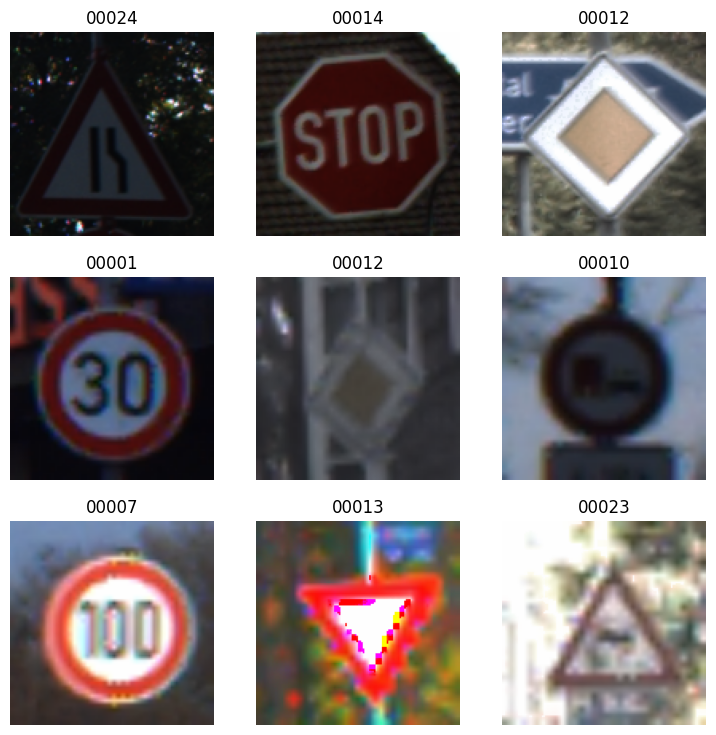

In [ ]:
dls.show_batch()

Let's check How Data Augmentation works on ResNet architechture

In [ ]:
learn = vision_learner(
    dls=dls,
    arch=resnet34,
    pretrained=False,
    loss_func=CrossEntropyLossFlat(),
    metrics=[
        accuracy,
        error_rate,
        RocAuc(average='macro'),
        Recall(average='macro'),
        Precision(average='macro'),
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SuggestedLRs(valley=0.0012022644514217973)

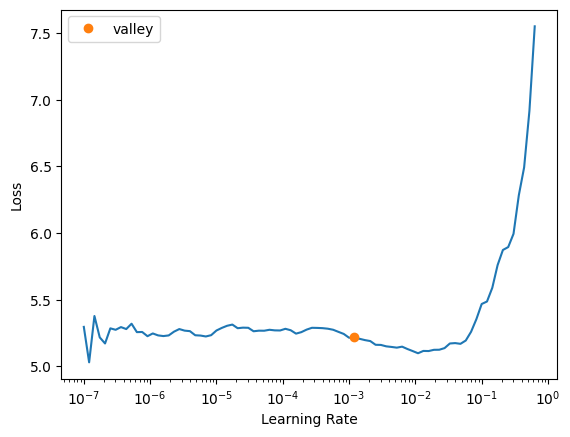

In [ ]:
learning_rate = learn.lr_find()
learning_rate

In [ ]:
# Train the model
learn.fit_one_cycle(5)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
data_aug_model = learn

In [ ]:
dl = data_aug_model.dls.test_dl(test_image_set)

In [ ]:
data_aug_resnet_preds = data_aug_model.get_preds(dl=dl, with_decoded=True)
data_aug_resnet_preds[2]

tensor([16,  1, 38,  ...,  5,  7, 10])

In [ ]:
acc = get_accuracy(data_aug_resnet_preds[2], y)
print("The accuracy for ResNet34 with Data Augmentation is: ", acc)

The accuracy for ResNet34 with Data Augmentation is:  0.9749010292953286


Trying to better our model with Data Augmentation:


In [ ]:
model = TrafficSignClassifier(num_classes=43)

In [ ]:
our_model = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=9.120108734350652e-05)

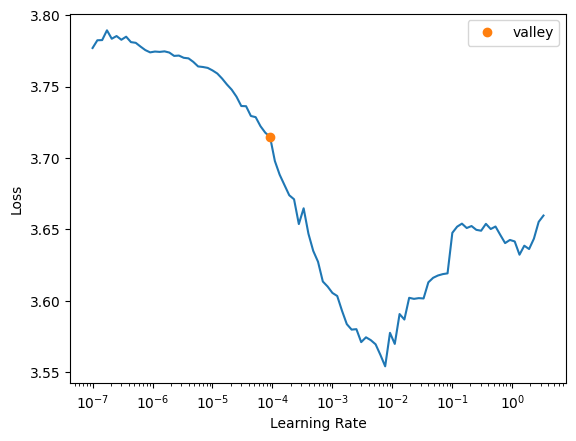

In [ ]:
learning_rate = our_model.lr_find()
learning_rate

In [ ]:
our_model.fit_one_cycle(10)

In [ ]:
dl = our_model.dls.test_dl(test_image_set)

In [ ]:
data_aug_predictions = our_model.get_preds(dl=dl, with_decoded=True)
data_aug_predictions[2]
##predictions = predict(model2, dl)

tensor([16,  1, 38,  ...,  5,  7, 10])

In [ ]:
acc = get_accuracy(data_aug_predictions[2], y)
print("The accuracy of our CNN architechture with Data Augmentation is: ", acc)
##acc = get_accuracy(predictions, y)

The accuracy with Data Augmentation is:  0.9045922406967538


Here, we can see that with Data Augmentation our Model's accuracy has increased from 0.850 to 0.9046, which is a decent increase.

### Comparison of ResNet architectures with Data Augmentation:

We'll be trying out and comparing ResNet18, ResNet34 & ResNet50

###### 1. ResNet18

In [ ]:
learn = vision_learner(
    dls=dls,
    arch=resnet18,
    pretrained=False,
    loss_func=CrossEntropyLossFlat(),
    metrics=[
        accuracy,
        error_rate,
        RocAuc(average='macro'),
        Recall(average='macro'),
        Precision(average='macro'),
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


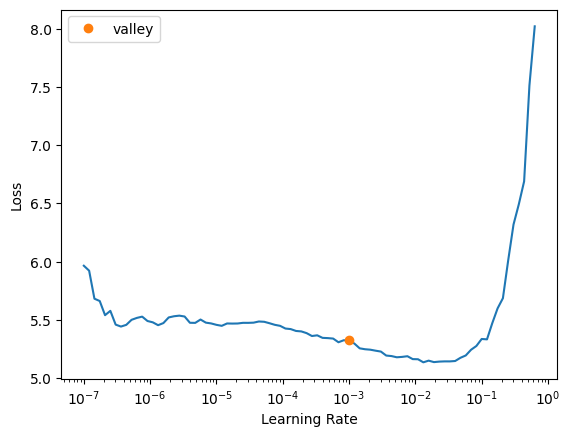

In [ ]:
learning_rate = learn.lr_find()
learn.fit_one_cycle(5, learning_rate[0])

In [ ]:
resnet18_TrainAcc = learn.validate()[1]
print(f"The training accuracy with batch size 32 is: {resnet18_TrainAcc}")

The training accuracy with batch size 32 is: 0.99793541431427


In [ ]:
if not os.path.exists(model_PATH):
   os.makedirs(model_PATH)

# Specify the path to save the model
model_path = os.path.join(model_PATH, "resnet18.pth")

# Save the trained model
learn.export(model_path)

# Print the path where the model is saved
print("Model saved at:", model_path)

Model saved at: /content/models/resnet18.pth


In [ ]:
resnet18_model=load_learner('/content/models/resnet18.pth')

In [ ]:
resnet18_model=load_learner('/content/models/resnet18.pth')

In [ ]:
dl = resnet18_model.dls.test_dl(test_image_set)

In [ ]:
resnet18_predictions = resnet18_model.get_preds(dl=dl, with_decoded=True)
resnet18_predictions[2]

tensor([16,  1, 38,  ...,  5,  7, 10])

In [ ]:
resnet18_TestAcc = get_accuracy(resnet18_predictions[2], y)
print("The test accuracy for ResNet18 model is: ", resnet18_TestAcc)

The test accuracy for ResNet18 model is:  0.9730799683293745


In [ ]:
dl = resnet18_model.dls.test_dl(test_image_set)

In [ ]:
resnet18_predictions = resnet18_model.get_preds(dl=dl, with_decoded=True)
resnet18_predictions[2]

tensor([16,  1, 38,  ...,  5,  7, 10])

In [ ]:
resnet18_TestAcc = get_accuracy(resnet18_predictions[2], y)
print("The test accuracy for ResNet18 model is: ", resnet18_TestAcc)

The test accuracy for ResNet18 model is:  0.9730799683293745


###### 2. ResNet34

We have majorly executed our models on ResNet34, which can be found above

###### 3. ResNet50

In [ ]:
learn = vision_learner(
    dls=dls,
    arch=resnet50,
    pretrained=False,
    loss_func=CrossEntropyLossFlat(),
    metrics=[
        accuracy,
        error_rate,
        RocAuc(average='macro'),
        Recall(average='macro'),
        Precision(average='macro'),
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


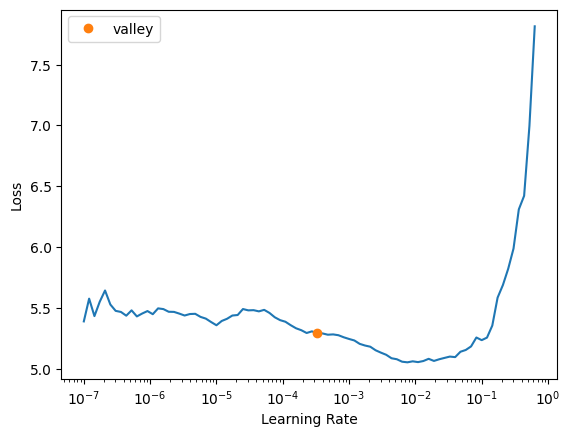

In [ ]:
learning_rate = learn.lr_find()
learn.fit_one_cycle(5, learning_rate[0])

In [ ]:
resnet50_TrainAcc = learn.validate()[1]
print(f"The training accuracy for ResNet50 is: {resnet50_TrainAcc}")

The training accuracy for ResNet50 is: 0.9938063025474548


In [ ]:
if not os.path.exists(model_PATH):
   os.makedirs(model_PATH)

# Specify the path to save the model
model_path = os.path.join(model_PATH, "resnet50.pth")

# Save the trained model
learn.export(model_path)

# Print the path where the model is saved
print("Model saved at:", model_path)

Model saved at: /content/models/resnet50.pth


In [ ]:
resnet50_model=load_learner('/content/models/resnet50.pth')

In [ ]:
dl = resnet50_model.dls.test_dl(test_image_set)

In [ ]:
resnet50_predictions = resnet50_model.get_preds(dl=dl, with_decoded=True)
resnet50_predictions[2]

tensor([16,  1, 38,  ..., 32,  7, 10])

In [ ]:
resnet50_TestAcc = get_accuracy(resnet50_predictions[2], y)
print("The test accuracy for ResNet50 is: ", resnet50_TestAcc)

The test accuracy for ResNet50 is:  0.9382422802850356


In [ ]:
resnet_TrainAcc = {
    '18': resnet18_TrainAcc,
    '34': bs32_TrainAcc,
    '50': resnet50_TrainAcc
}

resnet_TestAcc = {
    '18': resnet18_TestAcc,
    '34': bs32_TestAcc,
    '50': resnet50_TestAcc
}

for i in resnet_TrainAcc:
  print(f"The testing accuracy for ResNet{i} with Data Augmentation is: ", resnet_TrainAcc[i])

print("\n")

for i in resnet_TestAcc:
  print(f"The testing accuracy for ResNet{i} with Data Augmentation is: ", resnet_TestAcc[i])

The testing accuracy for ResNet18 is:  0.99793541431427
The testing accuracy for ResNet34 is:  0.9973723888397217
The testing accuracy for ResNet50 is:  0.9938063025474548


The testing accuracy for ResNet18 is:  0.9730799683293745
The testing accuracy for ResNet34 is:  0.9771179730799683
The testing accuracy for ResNet50 is:  0.9382422802850356


## Results

* Out of the ResNet architechtures, our (multiple) runs conclude that ResNet34 works best (with training accuracy above 98.5% and testing accuracy above 96.5%), with the batch size of 32 and for 5 training epochs.

* TrafficSignClassifier (the CNN architechture that we have built) works well with test accuracy of 90%.

* For predictions, we choose the ResNet34 Randomly initialised model [bs = 32]

## Saving the predictions in CSV

In [ ]:
import pandas as pd

In [ ]:
image_list = sorted(os.listdir(TESTSET_PATH))

In [ ]:
predicted_class = bs32_predictions[2]

pred_PATH = "/content/Predictions"
if not os.path.exists(pred_PATH):
   os.makedirs(pred_PATH)

# Specify the path to save the model
# pred_PATH = os.path.join(model_PATH, "predictions.csv")

# Create a DataFrame with image paths and predicted labels
results_df = pd.DataFrame({'Image_Path': test_image_set, 'Image': image_list, 'Predicted Class': predicted_class})

# Save the DataFrame to a CSV file
results_df.to_csv('./Predictions/predictions.csv', index=False, header=True)

In [ ]:
from google.colab import files
files.download('./Predictions/predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

References:



* https://docs.fast.ai/vision.learner.html
* https://docs.fast.ai/vision.augment.html
* https://docs.fast.ai/tutorial.datablock.html
* https://medium.com/unpackai/data-augmentation-with-fastai-library-b4f8ffb6f00d
*https://dirk-kalmbach.medium.com/datablock-and-dataloaders-in-fastai-d5aa7ae560e5
*https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895
*https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48 (CNN architechture)
*https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/
*https://vitalflux.com/handling-class-imbalance-sklearn-resample-python/
*https://towardsdatascience.com/how-to-deal-with-imbalanced-multiclass-datasets-in-python-fe0bb3f2b669
* https://towardsdatascience.com/how-to-handle-multiclass-imbalanced-data-say-no-to-smote-e9a7f393c310

